In [2]:
# Packages
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft, fftfreq
import pywt 
from skimage import measure
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 200

In [ ]:
def load_image(filepath):
    """Load and display an image with error checking."""
    # Check if file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Image file not found: {filepath}")
    print(f"File exists at: {os.path.abspath(filepath)}")
    
    # Try to load the image
    print("Attempting to load image...")
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    # Check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image: {filepath}")
    print(f"Image loaded successfully. Shape: {img.shape}")
    
    # Resize image
    print("Resizing image...")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    print(f"Image resized to: {img.shape}")
    
    # Display image
    print("Displaying image...")
    cv2.imshow('Loaded Image', img)
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()
    
    return img



File exists at: c:\Users\roths\Documents\dusts and bones\Tremor Tea\basicSpiral.png
Attempting to load image...
Image loaded successfully. Shape: (513, 499)
Resizing image...
Image resized to: (200, 200)
Displaying image...


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [65]:
# Convert pixel (i,j) to Cartesian (x,y)
def pixel_to_cartesian(img, i, j):
    x0, y0 = 0, IMG_SIZE  # center coordinates if starting at max r
    x1, y1 = IMG_SIZE, 0
    x = x0 + j * (x1 - x0) / (img.shape[1] - 1) - IMG_SIZE/2
    y = y1 + i * (y0 - y1) / (img.shape[0] - 1) - IMG_SIZE/2
    return x, y

# Convert (x,y) to polar coordinates (r, theta)
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(x,y)
    return r, theta

In [66]:
def extract_spiral_data(img, threshold=100):
    # Step 1: Identify black pixels based on intensity threshold
    spiral_points = np.column_stack(np.where(img > threshold))

    r_vals, theta_vals = [], []
    for (i, j) in spiral_points:
        # Convert pixel coordinates (i, j) to Cartesian coordinates (x, y)
        x, y = pixel_to_cartesian(img, i, j)
        # Convert (x, y) to polar coordinates (r, theta)
        r, theta = cartesian_to_polar(x, y)
        r_vals.append(r)
        theta_vals.append(theta)
    
    r_vals, theta_vals = np.array(r_vals), np.array(theta_vals)
    return r_vals, theta_vals

# Example usage
filepath = "image.png"
img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
r_vals, theta_vals = extract_spiral_data(img)

print("Extracted polar coordinates of the spiral:", list(zip(r_vals, theta_vals)))



Extracted polar coordinates of the spiral: [(np.float64(95.08015542948802), np.float64(3.0951975337717608)), (np.float64(95.0536527897074), np.float64(-3.0531842053093743)), (np.float64(95.02895631580219), np.float64(-3.0561662895301227)), (np.float64(95.00510535286705), np.float64(-3.0591498975950304)), (np.float64(94.98210053785095), np.float64(-3.0621349775129643)), (np.float64(94.95994248571243), np.float64(-3.065121477136565)), (np.float64(94.93863178933817), np.float64(-3.068109344167562)), (np.float64(94.91816901946426), np.float64(-3.0710985261621278)), (np.float64(94.89855472460034), np.float64(-3.0740889705362697)), (np.float64(94.87978943095668), np.float64(-3.0770806245712636)), (np.float64(94.86187364237396), np.float64(-3.080073435419116)), (np.float64(94.84480784025607), np.float64(-3.0830673501080668)), (np.float64(94.82859248350576), np.float64(-3.086062315548122)), (np.float64(94.81322800846327), np.float64(-3.0890582785366174)), (np.float64(94.79871482884784), np.flo

<function matplotlib.pyplot.show(close=None, block=None)>

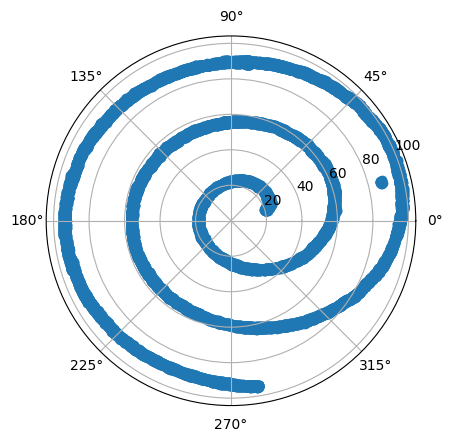

In [67]:
#for idx in range(len(r_vals)):
    #r_vals[idx] -= 512

ax = plt.subplot(111,polar = True)
ax.scatter(theta_vals,r_vals)

plt.show

Unwrapping the spiral
Assuming Archamedean spiral

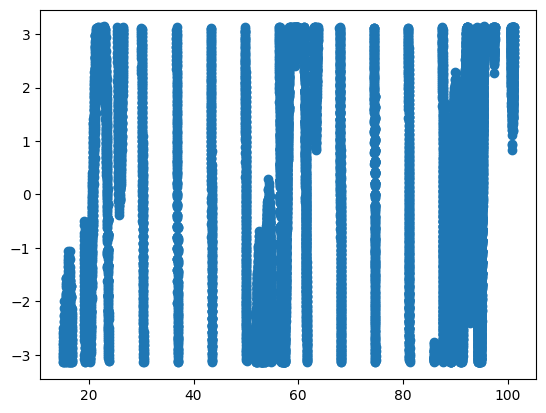

In [69]:

def unwrap(r_vals, theta_vals):
    r_p = [] 
    theta_p = []
    for r, theta in zip(r_vals,theta_vals):
        k = np.round((r - theta) / (2 * np.pi))
        nearest_theta = theta + 2 * k * np.pi 
        theta_p.append(nearest_theta) 
        r_p.append(nearest_theta - r)
    return r_p, theta_p

#Testing unwrap
r_p, theta_p = unwrap(r_vals, theta_vals)
plt.scatter(theta_p, r_p)
plt.show()

In [38]:
def fft_analysis(r_vals, theta_vals, freq_band):
    fft_result = fft(r_vals)
    freqs = np.fft.fftfreq(len(r_vals))
    # Filter for specific tremor frequency band
    freq_indices = np.where((freqs >= freq_band[0]) & (freqs <= freq_band[1]))
    tremor_fft = fft_result[freq_indices]
    peak_freq = freqs[np.argmax(np.abs(tremor_fft))]
    peak_amplitude = np.max(np.abs(tremor_fft))
    return peak_freq, peak_amplitude

# Power Spectral Density (PSD)
def psd_analysis(r_vals, fs=100):  # Assuming 100Hz sampling rate
    f, Pxx = welch(r_vals, fs=fs)
    return f, Pxx